Trial 254 Complete [00h 00m 10s]
val_accuracy: 0.6398809750874838

Best val_accuracy So Far: 0.6785714228947958
Total elapsed time: 00h 12m 36s
INFO:tensorflow:Oracle triggered exit

units_1 : 160
units_2 : 112
units_3 : 80
dropout_1 : 0.30000000000000004
dropout_2 : 0.25
learning_rate : 0.0008537572764607864
batch_size : 32

Epoch 1/100
32/32 [==============================] - 0s 4ms/step - loss: 1.9051 - accuracy: 0.4191 - val_loss: 2.0333 - val_accuracy: 0.5625
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5473 - accuracy: 0.5909 - val_loss: 1.8741 - val_accuracy: 0.5714
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 1.4159 - accuracy: 0.5958 - val_loss: 1.6805 - val_accuracy: 0.4821
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 1.2840 - accuracy: 0.5899 - val_loss: 1.4927 - val_accuracy: 0.4821
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 1.1578 - accuracy: 0.5978 - val_los

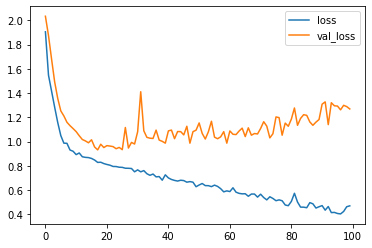

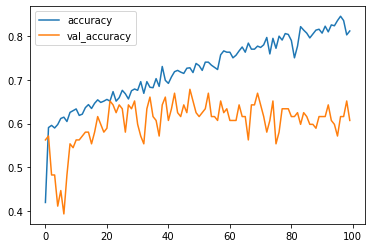

0.625


In [1]:

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import kerastuner as kt


# 하이퍼파리미터를 찾기 위해 모델에서 조정할 레이어의 값 범위를 지정해주고 추가로 학습률과 배치 크기의 값 범위를 추가로 지정해줍니다.
class MyHyperModel(kt.HyperModel):
  def build(self, hp):
    # hp_units1 = hp.Int('units_1', min_value = 16, max_value = 180)
    # hp_units2 = hp.Int('units_2', min_value = 16, max_value = 180)
    hp_units4 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.05)
    hp_units5 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.05)

    model = keras.Sequential()
    # model.add(layers.Dense(hp_units1, activation='relu', input_shape=[X_train.shape[1]]))
    for i in range(hp.Int('num_layers', 2, 5)):    #hidden layer의 개수를 2개부터 5개까지
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=16,
                                            max_value=180,
                                            step=16),    #layer의 node 개수를 16개부터 64개까지 16개의 간격으로
                               activation='relu'))
        model.add(layers.Dense())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp_units4))
    # model.add(layers.Dense(hp_units2, activation='relu'))
    # model.add(layers.BatchNormalization())
    # model.add(layers.Dropout(hp_units5))
    model.add(layers.Dense(9, activation='softmax'))


    hp_learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG')
    model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

  def fit(self, hp, model, *args, **kwargs):
      return model.fit(
          *args,
          batch_size=hp.Int('batch_size', min_value = 16, max_value = 256, step = 16),
          **kwargs,
      )



# Red Wine Quality 데이터셋을 로드합니다.
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
red_wine = pd.read_csv(BASE_DIR + '/' + 'datasets/winequality-red.csv')
red_wine = red_wine.dropna()


# 7:3 비율로 training dataset과 Test dataset으로 분리합니다.
df_train = red_wine.sample(frac=0.7, random_state=1234)
df_test = red_wine.drop(df_train.index)



# 특징과 라벨을 분리합니다.
X_train = df_train.drop('quality', axis=1).values
X_test = df_test.drop('quality', axis=1).values
y_train = df_train['quality'].values
y_test = df_test['quality'].values


# min-max normalization를 적용하여 특징 값의 범위를 0 ~ 1 사이로 변경합니다.
# 신경망은 입력이 공통 크기일 때 가장 잘 수행되는 경향이 있기 때문입니다.
# 이때 특징별로 min,max를 구하여 min-max normalization를 적용합니다.
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)



# One-hot 인코딩을 합니다.
y_train, y_test = to_categorical(y_train), to_categorical(y_test)



# 최적 하이퍼파라미터를 찾는 작업을 진행합니다.
tuner = kt.Hyperband(MyHyperModel(),
                    objective = 'val_accuracy',
                    max_epochs = 100,
                    executions_per_trial = 3,
                    overwrite = True,
                    factor = 3)

tuner.search(X_train, y_train, epochs = 100, validation_split = 0.1)



# 최적 하이퍼파라미터를 가져옵니다.
best_hps = tuner.get_best_hyperparameters()[0]



# 최적 하이퍼파라미터를 출력합니다.
print(f"""
units_1 : {best_hps.get('units_0')}
units_2 : {best_hps.get('units_1')}
units_3 : {best_hps.get('units_2')}
dropout_1 : {best_hps.get('dropout_1')}
dropout_2 : {best_hps.get('dropout_2')}
learning_rate : {best_hps.get('learning_rate')}
batch_size : {best_hps.get('batch_size')}
""")


# 배치 크기는 따로 저장했다가 fit 메소드에서 적용합니다.
batch_size = best_hps.get('batch_size')



# 최적값으로 모델을 생성합니다.
model = tuner.hypermodel.build(best_hps)


# 학습을 진행합니다.
# validation_split 아규먼트로 Training 데이터셋의 10%를 Validation 데이터셋으로 사용하도록합니다.
# 예를 들어 배치 크기가 256이라는 것은 전체 데이터셋을 샘플 256개씩으로 나누어서 학습에 사용한다는 의미입니다.
# 예를 들어 에포크(epochs)가 10이라는 것은 전체 train 데이터셋을 10번 본다는 의미입니다.
history = model.fit(
  X_train, y_train,
  validation_split = 0.1,
  batch_size=batch_size,
  epochs=100,
)


# 학습중 손실 변화를 그래프로 그립니다.
history_df = pd.DataFrame(history.history)
history_df['loss'].plot()
history_df['val_loss'].plot()
plt.legend()
plt.show()


history_df = pd.DataFrame(history.history)
history_df['accuracy'].plot()
history_df['val_accuracy'].plot()
plt.legend()
plt.show()


# Test 데이터셋으로 모델 성능 평가를 합니다.
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print(accuracy_score(y_test, y_pred))